## Imports

In [57]:
# Importing machine learning algorithms
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Importing other packages
import timeit
import pandas as pd
import numpy as np
import neptune
import tempfile
from scipy import stats
import time


import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import my_functions as mf

import mlflow
import mlflow.catboost
import os


# Importing packages for machine learning operations
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score


import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "browser"

## Start Experiment

In [58]:


# Set the experiment name in MLflow
instance_Family = 'General_purpose'
# General_purpose
# Memory_optimized
# Storage_optimized
# Compute_optimized
# GPU_instance

outlier = 'zscore'

# zscore
# iqr
# lof
# isolation


mlflow.set_experiment(instance_Family)
mlflow.set_tracking_uri("file:///media/gfragi/data/BarraCuda/mlruns/mlruns/")

### Add some experiment tags

In [59]:

# Set tags for the run
tags = {
    "experiment": "catboost_regression",
    "model_type": "CatBoostRegressor",
    # "task_type": "CPU",
    "dataset": "Amazon",
    "year to predict": "2022",
    "all years for prediction": "no",
    "outlier": outlier
}

# Set the tags for the current run
mlflow.set_tags(tags)

In [60]:
# mlflow.end_run()

## Import data 

In [61]:

data_all = pd.read_csv(
    f'./data/amazon_22_quarters.csv', parse_dates=['EffectiveDate'])


data_all = data_all[(data_all['instanceFamily'] == instance_Family)]

# data = data.drop(['OfferTermCode', 'instanceType', 'instanceFamily', 'OfferingClass'], axis=1)

data_all = data_all.drop(['SKU', 'RateCode', 'OfferTermCode', 'instanceFamily',
                          'License Model', 'TermType', 'year', 'Tenancy', 'OfferingClass',
                          'instanceType', 'Product Family', 'Current Generation',
                          'License Model'], axis=1)

In [62]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111740 entries, 12 to 554076
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   PricePerUnit         111740 non-null  float64       
 1   LeaseContractLength  111740 non-null  int64         
 2   PurchaseOption       111740 non-null  object        
 3   Location             111740 non-null  object        
 4   vCPU                 111740 non-null  int64         
 5   Memory               111740 non-null  int64         
 6   operatingSystem      111740 non-null  object        
 7   networkPerformance   111740 non-null  float64       
 8   EffectiveDate        111740 non-null  datetime64[ns]
 9   DiskType             111740 non-null  object        
 10  StorageSize          111740 non-null  int64         
 11  Quarter              111740 non-null  int64         
 12  YearQuarter          111740 non-null  object        
dtypes: datetime64

In [63]:
# Select regions

In [64]:
# # # replace USEast and USWest to US and EU to Europe
# data_all = data_all.replace({'USEast': 'US', 'USWest': 'US', 'EU': 'Europe'})
data_all = data_all[(data_all['Location'] != "Africa") & (data_all['Location'] != "MiddleEast") & (data_all['Location']
                                                                                                   != "Canada") & (data_all['Location'] != "SouthAmerica") & (data_all['Location'] != "AWSGovCloud")]

In [65]:
# data_all = data_all.drop(['Location'], axis=1)

In [66]:
# # create several new date time features
data_all['year'] = data_all['EffectiveDate'].dt.year
# data['day_of_year'] = data['EffectiveDate'].dt.dayofyear
# data['weekday'] = data['EffectiveDate'].dt.weekday
# data['week_of_year'] = data['EffectiveDate'].dt.week
# data['day_of_month'] = data['EffectiveDate'].dt.day
# data['quarter'] = data['EffectiveDate'].dt.quarter

# data.drop('EffectiveDate', axis=1, inplace=True)

### Sort 

In [67]:
data_all.sort_values(by='EffectiveDate')
data_all.reset_index(drop=True)

,PricePerUnit,LeaseContractLength,PurchaseOption,Location,vCPU,Memory,operatingSystem,networkPerformance,EffectiveDate,DiskType,StorageSize,Quarter,YearQuarter,year
0,0.11400,3,No Upfront,AsiaPacific,2,7,Linux,0.3,2016-09-30,SSD,32,3,2016Q3,2016
1,0.05800,1,Partial Upfront,AsiaPacific,2,7,Linux,0.3,2016-09-30,SSD,32,3,2016Q3,2016
2,0.12700,1,No Upfront,AsiaPacific,2,7,Linux,0.3,2016-08-31,SSD,32,3,2016Q3,2016
3,0.04700,3,Partial Upfront,US,2,7,Linux,0.3,2016-09-30,SSD,32,3,2016Q3,2016
4,0.05300,1,Partial Upfront,US,2,7,Linux,0.3,2016-09-30,SSD,32,3,2016Q3,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91921,1.90853,1,Partial Upfront,AsiaPacific,8,32,Windows,12500.0,2022-10-01,SSD,474,4,2022Q4,2022
91922,3.62564,3,No Upfront,AsiaPacific,8,32,Windows,12500.0,2022-10-01,SSD,474,4,2022Q4,2022
91923,3.83952,1,No Upfront,AsiaPacific,8,32,Windows,12500.0,2022-10-01,SSD,474,4,2022Q4,2022
91924,3.74373,1,No Upfront,AsiaPacific,8,32,Windows,12500.0,2022-10-01,SSD,474,4,2022Q4,2022


In [68]:
data_all['year'].value_counts()

2022    28032
2020    25260
2021    15744
2019    13376
2018     6640
2016     2050
2017      824
Name: year, dtype: int64

# Outlier Methods

## IsolationForest

In [69]:
from sklearn.ensemble import IsolationForest

if outlier == 'isolation':

    # Select the column(s) you want to detect outliers in
    columns_to_check = ['PricePerUnit', 'vCPU', 'Memory']

    # Create an Isolation Forest object
    # Adjust the contamination parameter as needed
    isolation_forest = IsolationForest(contamination=0.1)

    # Fit the Isolation Forest model and predict outlier labels
    outlier_labels = isolation_forest.fit_predict(data_all[columns_to_check])

    # Identify outliers based on the predicted labels
    outliers = data_all[outlier_labels == -1]

    # Exclude outliers from the dataset
    data_all = data_all[outlier_labels != -1]

    # Print the outliers
    print("Outliers:")
    print(outliers)

    # Print the cleaned dataset
    print("Cleaned Data:")
    print(data_all)

## LOF

In [70]:
from sklearn.neighbors import LocalOutlierFactor


if outlier == 'lof':

    # Select the column(s) you want to detect outliers in
    columns_to_check = ['PricePerUnit']

    # Create a LOF object
    # Adjust parameters as needed
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

    # Fit the LOF model and predict outlier scores
    outlier_scores = lof.fit_predict(data_all[columns_to_check])

    # Identify outliers based on the predicted scores
    outliers = data_all[outlier_scores == -1]

    # Exclude outliers from the dataset
    data_all = data_all[outlier_scores != -1]

    # Print the outliers
    print("Outliers:")
    print(outliers)

    # Print the cleaned dataset
    print("Cleaned Data:")
    print(data_all)
else:
    pass

## Interquartile Range (IQR)



In [71]:

if outlier == 'iqr':
    # Select the column(s) you want to detect outliers in
    columns_to_check = ['PricePerUnit']

    # Calculate the IQR for each column
    Q1 = data_all[columns_to_check].quantile(0.25)
    Q3 = data_all[columns_to_check].quantile(0.75)
    IQR = Q3 - Q1

    # Define a threshold for identifying outliers
    threshold = 2

    # Determine the lower and upper bounds for outlier detection
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # Identify outliers by filtering the dataset
    outliers = data_all[~((data_all[columns_to_check] >= lower_bound) & (
        data_all[columns_to_check] <= upper_bound)).all(axis=1)]

    # Exclude outliers from the dataset
    data_all = data_all[((data_all[columns_to_check] >= lower_bound) & (
        data_all[columns_to_check] <= upper_bound)).all(axis=1)]

    # Print the outliers
    print("Outliers:")
    print(outliers)

    # Print the cleaned dataset
    print("Cleaned Data:")
    print(data_all)
else:
    pass

## Z-score

In [72]:
if outlier == 'zscore':

    # Select the column(s) you want to detect outliers in
    columns_to_check = ['PricePerUnit']

    # Compute the Z-scores for each data point
    z_scores = np.abs(stats.zscore(data_all[columns_to_check]))

    # Define a threshold for identifying outliers
    threshold = 0.75

    # Find the indices of outliers
    outlier_indices = np.where(z_scores > threshold)

    # Get the rows containing outliers
    outliers = data_all.iloc[outlier_indices[0]]

    # Exclude outliers from the dataset
    data_all = data_all.drop(data_all.index[outlier_indices[0]])

    # Print the outliers
    print(outliers)

    mlflow.log_param("z-threshold", threshold)

else:
    pass

        PricePerUnit  LeaseContractLength   PurchaseOption Location  vCPU  \
52061       10.11800                    1       No Upfront       US    48   
52104       22.35800                    1       No Upfront       US    48   
52113       11.13200                    1  Partial Upfront       US    48   
52143       21.73700                    3       No Upfront       US    48   
52144       10.81800                    3  Partial Upfront       US    48   
...              ...                  ...              ...      ...   ...   
553696      14.84271                    3       No Upfront   Europe    32   
553774       9.99768                    1       No Upfront       US    96   
553997      14.45903                    3       No Upfront   Europe    32   
553998      15.33933                    1       No Upfront   Europe    32   
553999      14.91142                    1       No Upfront   Europe    32   

        Memory operatingSystem  networkPerformance EffectiveDate  DiskType 

##  Create a quarterly seasonality column


In [73]:
# # Convert EffectiveDate column to datetime format
# data_all['EffectiveDate'] = pd.to_datetime(data_all['EffectiveDate'])

# # Extract the quarter component from the EffectiveDate column
# data_all['Quarter'] = data_all['EffectiveDate'].dt.quarter


# # Combine year and quarter into a single column
# data_all['YearQuarter'] = data_all['year'].astype(
#     str) + '-Q' + data_all['Quarter'].astype(str)

In [74]:
# data_all

# data_all = data_all.drop(['Seasonality'], axis=1)

# Prepare the Data

In [75]:
# %%  =========== Prepare the Data for regression============

# Map binary categorical columns to numerical

categorical_binary = ['PurchaseOption']
data_all[categorical_binary] = data_all[categorical_binary].apply(
    mf.binary_map)

# Write the categorical values as a list
# categorical = ['operatingSystem', 'DiskType', 'Location', 'instanceFamily']
categorical = ['operatingSystem', 'DiskType']
categorical2numeric = pd.get_dummies(data_all[categorical], drop_first=False)

categorical2numeric_pred = pd.get_dummies(
    data_all[categorical], drop_first=False)

# Add the above results to the original dataframe df
data_all = pd.concat([data_all, categorical2numeric], axis=1)
data_all.drop(columns=categorical, axis=1, inplace=True)

# Years

In [76]:
data_all.year.unique()

array([2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [77]:
data_pred = data_all[data_all['year'] > 2021]
data_pred = data_pred.sort_values(by='EffectiveDate')
data_pred = data_pred.reset_index(drop=True)
data_pred.year.unique()

array([2022])

In [78]:
data = data_all[(data_all['year'] > 2020) & (data_all['year'] < 2022)]
data = data.sort_values(by='EffectiveDate')
data = data.reset_index(drop=True)
data.year.unique()


mlflow.log_param("Years used to predict", data.year.unique())

array([2021])

## Assign target value

In [79]:
X = data.drop(['PricePerUnit', 'EffectiveDate',
              'YearQuarter', 'Location'], axis=1)
y = data.PricePerUnit

# CatBoost Model Training

In [80]:
# CatBoost Model Training
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [81]:
model = CatBoostRegressor(iterations=50, depth=3,
                          learning_rate=0.1, loss_function='RMSE')

# cat_features=categorical_features_indices
model.fit(X_train, y_train,
          eval_set=(X_valid, y_valid), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.5889654	test: 1.6601876	best: 1.6601876 (0)	total: 696us	remaining: 34.1ms
1:	learn: 1.5203531	test: 1.5878199	best: 1.5878199 (1)	total: 1.57ms	remaining: 37.8ms
2:	learn: 1.4591914	test: 1.5238870	best: 1.5238870 (2)	total: 2.27ms	remaining: 35.5ms
3:	learn: 1.4076483	test: 1.4694169	best: 1.4694169 (3)	total: 2.98ms	remaining: 34.3ms
4:	learn: 1.3637426	test: 1.4237329	best: 1.4237329 (4)	total: 3.65ms	remaining: 32.9ms
5:	learn: 1.3221285	test: 1.3783262	best: 1.3783262 (5)	total: 4.38ms	remaining: 32.1ms
6:	learn: 1.2852433	test: 1.3392415	best: 1.3392415 (6)	total: 5.04ms	remaining: 31ms
7:	learn: 1.2530506	test: 1.3051515	best: 1.3051515 (7)	total: 5.75ms	remaining: 30.2ms
8:	learn: 1.2254143	test: 1.2740585	best: 1.2740585 (8)	total: 6.45ms	remaining: 29.4ms
9:	learn: 1.2004050	test: 1.2468484	best: 1.2468484 (9)	total: 7.14ms	remaining: 28.6ms
10:	learn: 1.1805055	test: 1.2259315	best: 1.2259315 (10)	total: 7.85ms	remaining: 27.8ms
11:	learn: 1.1607242	test: 1.2030

# Catboost Model

### Catboost Regressor parameters

In [82]:
start = time.time()

model = CatBoostRegressor(iterations=15000,
                          loss_function='RMSE',
                          # 0.001 - 0.1 A lower learning rate results in slower but more precise convergence
                          learning_rate=0.001,
                          # 4 - 10  Higher values allow the model to capture more complex interactions but can increase the risk of overfitting.
                          depth=16,
                          custom_metric=['MAPE', 'RMSE', 'MAE', 'R2'],
                          random_seed=42,
                          bagging_temperature=0.2,  # 0 - 1
                          # Can be 'Iter' or 'IncToDec'. 'Iter' stops training when the evaluation metric stops improving, and 'IncToDec' stops when the evaluation metric starts to worsen.
                          od_type='Iter',
                          metric_period=75,  # how frequently the evaluation metric is calculated during training
                          task_type='GPU',  # Enable GPU training
                          # number of iterations to wait for the evaluation metric to improve before stopping training.
                          od_wait=100,
                          #   cat_features=['PurchaseOption', 'Location',
                          #                 'operatingSystem', 'DiskType']
                          )

# Log specific parameters of the CatBoost model
params_to_track = ['iterations', 'learning_rate', 'depth', 'loss_function', 'bagging_temperature',
                   'random_seed', 'metric_period', 'od_wait', 'task_type']
for param in params_to_track:
    param_value = model.get_params().get(param)
    mlflow.log_param(param, str(param_value))

In [83]:
# mlflow.end_run()

In [84]:
model.fit(X_train, y_train,
          eval_set=(X_valid, y_valid),
          use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 1.6686107	test: 1.7434764	best: 1.7434764 (0)	total: 20.3ms	remaining: 5m 5s
75:	learn: 1.5929999	test: 1.6649044	best: 1.6649044 (75)	total: 8.02s	remaining: 26m 15s
150:	learn: 1.5243142	test: 1.5932966	best: 1.5932966 (150)	total: 13.2s	remaining: 21m 42s
225:	learn: 1.4624794	test: 1.5285740	best: 1.5285740 (225)	total: 18.7s	remaining: 20m 24s
300:	learn: 1.4069902	test: 1.4701465	best: 1.4701465 (300)	total: 25.1s	remaining: 20m 24s
375:	learn: 1.3569070	test: 1.4171801	best: 1.4171801 (375)	total: 31.3s	remaining: 20m 16s
450:	learn: 1.3112045	test: 1.3687325	best: 1.3687325 (450)	total: 36.8s	remaining: 19m 46s
525:	learn: 1.2704424	test: 1.3252327	best: 1.3252327 (525)	total: 42.9s	remaining: 19m 41s
600:	learn: 1.2338344	test: 1.2859167	best: 1.2859167 (600)	total: 54.1s	remaining: 21m 36s
675:	learn: 1.2006484	test: 1.2502055	best: 1.2502055 (675)	total: 1m 2s	remaining: 22m 3s
750:	learn: 1.1710152	test: 1.2181111	best: 1.2181111 (750)	total: 1m 8s	remaining: 21m 

In [85]:
mlflow.catboost.log_model(model, "catboost_model")

best_iteration = model.get_best_iteration()

mlflow.log_metric('best_iteration', best_iteration)

2023/07/02 23:50:18 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


## Plot the Feature Importance

In [86]:

fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[
                              True, False]).iloc[-30:]

fig = go.Figure(data=[go.Bar(
    x=fea_imp['imp'],
    y=fea_imp['col'],
    orientation='h',
    marker=dict(color=fea_imp['imp'], colorbar=dict(title='Importance'))

)])

fig.update_layout(
    title='CatBoost - Feature Importance - All',
    yaxis=dict(title='Features'),
    xaxis=dict(title='Importance'),
    height=600,
    width=800
)

# fig.show()


# Save the Plotly figure as an HTML file
html_path = "temp/feature_importance_all.html"
pio.write_html(fig, html_path)

# Log the HTML file as an artifact in MLflow
mlflow.log_artifact(html_path)

### Log feature importance - mlflow

In [87]:
# Get the feature importance values and feature names from your CatBoost model
feature_importance = model.get_feature_importance()
feature_names = X.columns

# Create a DataFrame to store the feature importance values and feature names
feature_importance_df = pd.DataFrame(
    {'Feature': feature_names, 'Importance': feature_importance})

# Create a temporary file to save the feature importance DataFrame
with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.csv') as temp_file:
    # Save the feature importance DataFrame as a CSV file
    feature_importance_df.to_csv(temp_file, index=False)

# Log the feature importance CSV file as an artifact in MLflow
mlflow.log_artifact(temp_file.name, "feature_importance.csv")

In [88]:
# import pandas as pd
# import tempfile

# # Define the years sets
# years_sets = [
#     [2020, 2021],
#     [2019, 2020, 2021],
#     [2018, 2019, 2020, 2021],
#     [2021]
# ]

# # Create a DataFrame to store the feature importance values and feature names
# feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# # Insert the year sets as the first column in the DataFrame
# feature_importance_df.insert(0, 'Year Sets', years_sets)

# # Create a temporary file to save the feature importance DataFrame
# with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.csv') as temp_file:
#     # Save the feature importance DataFrame as a CSV file
#     feature_importance_df.to_csv(temp_file, index=False)

# # Log the feature importance CSV file as an artifact in MLflow
# mlflow.log_artifact(temp_file.name, "feature_importance.csv")

### Evalute Model

In [89]:
# model evaluation
from sklearn.metrics import mean_squared_error
print('Model evaluation:')
print(model.get_params())
print('RMSE:', np.sqrt(mean_squared_error(y_valid, model.predict(X_valid))))

Model evaluation:
{'iterations': 15000, 'learning_rate': 0.001, 'depth': 16, 'loss_function': 'RMSE', 'od_wait': 100, 'od_type': 'Iter', 'random_seed': 42, 'metric_period': 75, 'custom_metric': ['MAPE', 'RMSE', 'MAE', 'R2'], 'bagging_temperature': 0.2, 'task_type': 'GPU'}
RMSE: 0.9356972313302702


In [90]:
print(model.get_best_score())

# Flatten and log the best scores as parameters in MLflow
best_scores = model.get_best_score()
for stage, metrics in best_scores.items():
    for metric, value in metrics.items():
        mlflow.log_metric(f'{stage}_{metric}', value)

{'learn': {'MAE': 0.45574139848228684, 'MAPE': 0.2289126487412106, 'R2': 0.6935327155369948, 'RMSE': 0.9243261442127093}, 'validation': {'MAE': 0.4544463898147837, 'MAPE': 0.22241709451403816, 'R2': 0.7122807678626045, 'RMSE': 0.9356982310998039}}


In [91]:
# End the MLflow run
# mlflow.end_run()

### Finish without shap

## SHAP

In [92]:
# import shap

# pool = cb.Pool(X_valid, y_valid)


# # Compute SHAP values
# shap_values = model.get_feature_importance(pool, type='ShapValues')

# # Convert SHAP values to a DataFrame
# shap_df = pd.DataFrame(shap_values[:, :-1], columns=X_valid.columns)

# # Log the SHAP values as an artifact in MLflow
# shap_df.to_csv("shap_values.csv", index=False)
# mlflow.log_artifact("shap_values.csv")

In [93]:
# # Exclude the constant offset column from shap_values
# shap_values = shap_values[:, :-1]

# # Create a SHAP summary plot
# shap.summary_plot(shap_values, X_valid)

# # Save the plot as an artifact in MLflow
# shap_plot_path = 'shap_summary_plot.png'
# shap.summary_plot(shap_values, X_valid, show=False)
# plt.savefig(shap_plot_path)
# mlflow.log_artifact(shap_plot_path)

# Evaluation


## Predictions vs Actual Prices

In [94]:
# predict(data,
#         prediction_type=None,
#         ntree_start=0,
#         ntree_end=0,
#         thread_count=-1,
#         verbose=None)

In [95]:
# data_pred = data_pred.drop(['PricePerUnit'], axis=1)

data_pred = data_pred.drop(['Location', 'YearQuarter'], axis=1)

predictions = model.predict(data_pred)

# Create a DataFrame with the predictions
predictions_df = pd.DataFrame(predictions, columns=['Predictions'])

# Save the predictions to a CSV file
predictions_df.to_csv('temp/predictions.csv', index=False)

# Log the predictions CSV file as an artifact in MLflow
mlflow.log_artifact('temp/predictions.csv', 'predictions')

In [96]:
predictions

array([5.14465917, 2.07047973, 2.12503755, ..., 0.71618213, 0.59379905,
       0.73419758])

In [97]:
actual_prices = data_pred.PricePerUnit

In [98]:

import plotly.graph_objects as go

# Create a line plot using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(actual_prices))),
              y=actual_prices, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=list(range(len(predictions))),
              y=predictions, mode='lines', name='Predicted'))

fig.update_layout(
    title='Actual vs. Predicted Prices for 2022',
    xaxis=dict(title='Samples'),
    yaxis=dict(title='Price ($) Per Hour')
)

# fig.show()

# Save the Plotly figure as an HTML file
html_path = "temp/actual_predicted.html"
pio.write_html(fig, html_path)

# Log the HTML file as an artifact in MLflow
mlflow.log_artifact(html_path)

In [99]:
rmse = mean_squared_error(actual_prices, predictions, squared=False)

In [100]:
rmse

1.7041020932903943

In [101]:
error = actual_prices - predictions

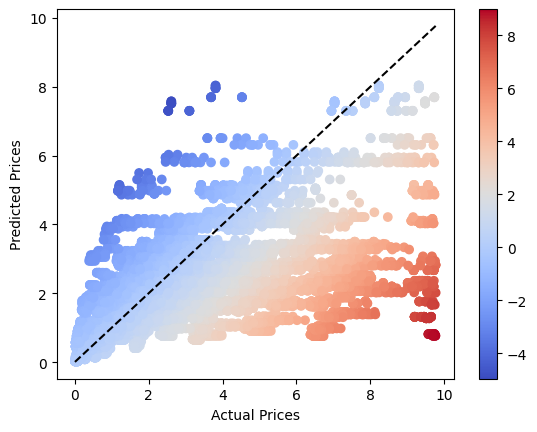

In [102]:
plt.scatter(actual_prices, predictions, c=error, cmap='coolwarm')
plt.plot(np.linspace(min(actual_prices), max(actual_prices), 100), np.linspace(
    min(actual_prices), max(actual_prices), 100), color='black', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.colorbar()
plt.show()

In [103]:
# Create a scatter plot using Plotly
fig = go.Figure(data=go.Scatter(
    x=actual_prices,
    y=predictions,
    mode='markers',
    marker=dict(
        size=8,
        color=error,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='Error')
    )
))

fig.update_layout(
    title='Actual vs. Predicted Prices',
    xaxis=dict(title='Actual Prices'),
    yaxis=dict(title='Predicted Prices')
)

# fig.show()

# Save the Plotly figure as an HTML file
html_path = "temp/actual_predicted_errors.html"
pio.write_html(fig, html_path)

# Log the HTML file as an artifact in MLflow
mlflow.log_artifact(html_path)

In [104]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error


mse = mean_squared_error(actual_prices, predictions)
rmse = mean_squared_error(actual_prices, predictions, squared=False)
mae = mean_absolute_error(actual_prices, predictions)
r2 = r2_score(actual_prices, predictions)
mape = mean_absolute_percentage_error(actual_prices, predictions)

In [105]:
mlflow.log_metric("MSE", mse)
mlflow.log_metric("RMSE", rmse)
mlflow.log_metric("MAE", mae)
mlflow.log_metric("MAPE", mape)
mlflow.log_metric("R-squared", r2)

# mlflow.log_metric()

In [106]:
print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)
print('R-squared:', r2)

MSE: 2.9039639443567036
RMSE: 1.7041020932903943
MAE: 0.9866234218685098
MAPE: 0.9266152716871214
R-squared: 0.3932549710130706


https://towardsdatascience.com/ad-demand-forecast-with-catboost-lightgbm-819e5073cd3e

https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285

In [107]:
# End the MLflow run
mlflow.end_run()